In [6]:
def fs_p_value(df):
    p_val_table = pd.DataFrame(0, index=df.columns[1:], columns=['p_val'])
    cata = pd.DataFrame(df.loc[:,'group'].value_counts()).index
    if len(cata) == 2:
        df1 = df.loc[df.loc[:,'group'] == cata[0],:].iloc[:,1:]
        df2 = df.loc[df.loc[:,'group'] == cata[1],:].iloc[:,1:]
        for i in p_val_table.index:
            p_val = pg.mwu(x=df1.loc[:,i],
                           y=df2.loc[:,i],
                           tail='two-sided').loc[:,'p-val'].values[0]
            p_val_table.loc[i,:] = p_val
    elif len(cata) > 2:
        for i in p_val_table.index:
            p_val = pg.kruskal(data=df, 
                               dv=i, 
                               between='group').loc[:,'p-unc'].values[0]
            p_val_table.loc[i,:] = p_val
    return p_val_table

In [7]:
def feature_selections(X, y, classifiers_fs):
    data_with_group = pd.concat([pd.DataFrame(y, columns=['group'], index=X.index), X], axis=1)
    p_value_table = fs_p_value(data_with_group)
    table_for_fs = pd.concat([p_value_table.transpose(), X], axis=0).sort_values(by='p_val', axis=1, ascending=True)
    fs_num = list(range(1, round(len(X.columns) / 10)  - 1))
    fs_num = [element * 10 for element in fs_num if element <= 100]
    result_list = []
    for i in fs_num:
        X_for_train = table_for_fs.iloc[1:, :i]
        for j in list(classifiers_fs.keys()):
            model = classifiers_fs[j]
            val_result = model_selection.cross_validate(model, X_for_train, y, scoring=['accuracy'], 
                                                cv=5, return_train_score=True)
            train_accuracy = val_result['train_accuracy']
            test_accuracy = val_result['test_accuracy']
            train_mean = train_accuracy.mean()
            train_std = train_accuracy.std()
            test_mean = test_accuracy.mean()
            test_std = test_accuracy.std()
            name_i = "%s_%d" %(j, i)
            result_list.append([name_i, train_mean, train_std, test_mean, test_std])
    result_table = pd.DataFrame(result_list, 
                            columns=['model_fs_num', 'train_mean', 'train_std', 'test_mean', 'test_std'])
    result_table = result_table.set_index('model_fs_num', drop = True)
    return(result_table)

In [8]:
root="/projects/ohlab/ruoyun/MECFS/train_model/MECFS"
kegg_table="kegg_gene_filtered_normalized_070220.txt"
abundance_table="metaphlan3_specie_filtered_zscored_071020.csv"
metabolomics_table="metabolomics_normalized_filtered_071020.csv"
meta_table="MECFS_metadata_lables_062320.csv"

In [9]:
import pandas as pd
import numpy as np
import pingouin as pg
import glob

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [11]:
#grid search
from sklearn.model_selection import RandomizedSearchCV

#save model
from joblib import dump, load

#validation
from sklearn import model_selection

In [12]:
random_num = 1015

---

# import dataset here

In [18]:
rela_abun = pd.read_csv("%s/data/metagenomics/%s" %(root, abundance_table), 
                   index_col=0)
rela_abun_decode = rela_abun.iloc[:,:14]
rela_abun_data = rela_abun.iloc[:,14:]
print(rela_abun_decode.shape)
print(rela_abun_data.shape)

kegg = pd.read_table("%s/data/metagenomics/%s" %(root, kegg_table), 
                     sep='\t', index_col=0)
kegg_decode = kegg.iloc[:,:1]
kegg_data = kegg.iloc[:,1:]
print(kegg_decode.shape)
print(kegg_data.shape)

bioc = pd.read_csv("%s/data/metabolomics/%s" %(root, metabolomics_table), 
                   index_col=0)
bioc_decode = bioc.iloc[:,:12]
bioc_data = bioc.iloc[:,12:]
print(bioc_decode.shape)
print(bioc_data.shape)

meta = pd.read_csv("%s/data/metadata/%s" %(root, meta_table), 
                   index_col=0)
meta_decode = meta.iloc[:, :4]
meta_data = meta.iloc[:, 4:]

print(meta_data.shape)

(169, 14)
(169, 224)
(3447, 1)
(3447, 224)
(1176, 12)
(1176, 184)
(5, 228)


# Define classifiers

In [19]:
classifiers_list = {
    'logistic': LogisticRegression(C=1, l1_ratio=0, max_iter=100000000.0,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=random_num, solver='saga', tol=0.0001, verbose=0),
    'svm': SVC(C=1, decision_function_shape='ovr', max_iter=-1, 
               probability=True, random_state=random_num, tol=0.0001, verbose=False),
    'gdbt': GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=random_num),
    'rf' : RandomForestClassifier(bootstrap=True, n_estimators=100, random_state=random_num)
}

# Patient vs Control

In [56]:
y_full = meta_data.loc['study_ptorhc', :]

In [57]:
X = rela_abun_data[:].transpose()
y = y_full[X.index].to_numpy()
#feature_selections(X, y, 
#                   classifiers_list).to_csv("%s/result/feature_selection/patient_control_abun_fs_result.csv" %(root))

In [58]:
data_with_group = pd.concat([pd.DataFrame(y, columns=['group'], index=X.index), X], axis=1)
p_value_table = fs_p_value(data_with_group)
print("taxo p value < 0.05: %d" % (len(p_value_table.loc[p_value_table.iloc[:,0].to_numpy() <= 0.05, :])))
print("taxo p value < 0.1: %d" % (len(p_value_table.loc[p_value_table.iloc[:,0].to_numpy() <= 0.1, :])))

taxo p value < 0.05: 73
taxo p value < 0.1: 85


In [53]:
X = kegg_data[:].transpose()
y = y_full[X.index].to_numpy()
#feature_selections(X, y, 
#                   classifiers_list).to_csv("%s/result/feature_selection/patient_control_kegg_fs_result.csv" %(root))

In [55]:
data_with_group = pd.concat([pd.DataFrame(y, columns=['group'], index=X.index), X], axis=1)
p_value_table = fs_p_value(data_with_group)
print("gene set p value < 0.05: %d" % (len(p_value_table.loc[p_value_table.iloc[:,0].to_numpy() <= 0.05, :])))
print("gene set p value < 0.1: %d" % (len(p_value_table.loc[p_value_table.iloc[:,0].to_numpy() <= 0.1, :])))

gene set p value < 0.05: 702
gene set p value < 0.1: 961


In [51]:
X = bioc_data[:].transpose()
y = y_full[X.index].to_numpy()
#feature_selections(X, y, 
#                   classifiers_list).to_csv("%s/result/feature_selection/patient_control_bioc_fs_result.csv" %(root))

In [52]:
data_with_group = pd.concat([pd.DataFrame(y, columns=['group'], index=X.index), X], axis=1)
p_value_table = fs_p_value(data_with_group)
print("metabolomics p value < 0.05: %d" % (len(p_value_table.loc[p_value_table.iloc[:,0].to_numpy() <= 0.05, :])))
print("metabolomics p value < 0.1: %d" % (len(p_value_table.loc[p_value_table.iloc[:,0].to_numpy() <= 0.1, :])))

metabolomics p value < 0.05: 249
metabolomics p value < 0.1: 334


# Onset

In [59]:
y_full = meta_data.loc['illness_duration', :]

In [60]:
X = rela_abun_data[:].transpose()
y = y_full[X.index].to_numpy()
#feature_selections(X, y, 
#                   classifiers_list).to_csv("%s/result/feature_selection/onset_abun_fs_result.csv" %(root))

In [61]:
data_with_group = pd.concat([pd.DataFrame(y, columns=['group'], index=X.index), X], axis=1)
p_value_table = fs_p_value(data_with_group)
print("taxo p value < 0.05: %d" % (len(p_value_table.loc[p_value_table.iloc[:,0].to_numpy() <= 0.05, :])))
print("taxo p value < 0.1: %d" % (len(p_value_table.loc[p_value_table.iloc[:,0].to_numpy() <= 0.1, :])))

taxo p value < 0.05: 63
taxo p value < 0.1: 72


In [62]:
X = kegg_data[:].transpose()
y = y_full[X.index].to_numpy()
#feature_selections(X, y, 
#                  classifiers_list).to_csv("%s/result/feature_selection/onset_kegg_fs_result.csv" %(root))

In [63]:
data_with_group = pd.concat([pd.DataFrame(y, columns=['group'], index=X.index), X], axis=1)
p_value_table = fs_p_value(data_with_group)
print("gene set p value < 0.05: %d" % (len(p_value_table.loc[p_value_table.iloc[:,0].to_numpy() <= 0.05, :])))
print("gene set p value < 0.1: %d" % (len(p_value_table.loc[p_value_table.iloc[:,0].to_numpy() <= 0.1, :])))

gene set p value < 0.05: 835
gene set p value < 0.1: 1170


In [65]:
X = bioc_data[:].transpose()
y = y_full[X.index].to_numpy()
#feature_selections(X, y, 
#                   classifiers_list).to_csv("%s/result/feature_selection/onset_bioc_fs_result.csv" %(root))

In [66]:
data_with_group = pd.concat([pd.DataFrame(y, columns=['group'], index=X.index), X], axis=1)
p_value_table = fs_p_value(data_with_group)
print("gene set p value < 0.05: %d" % (len(p_value_table.loc[p_value_table.iloc[:,0].to_numpy() <= 0.05, :])))
print("gene set p value < 0.1: %d" % (len(p_value_table.loc[p_value_table.iloc[:,0].to_numpy() <= 0.1, :])))

gene set p value < 0.05: 318
gene set p value < 0.1: 437


# Plot

In [4]:
filenames = glob.glob("%s/result/feature_selection/*_fs_result.csv" %(root))
file = [pd.read_csv(f, index_col = 0) for f in filenames]

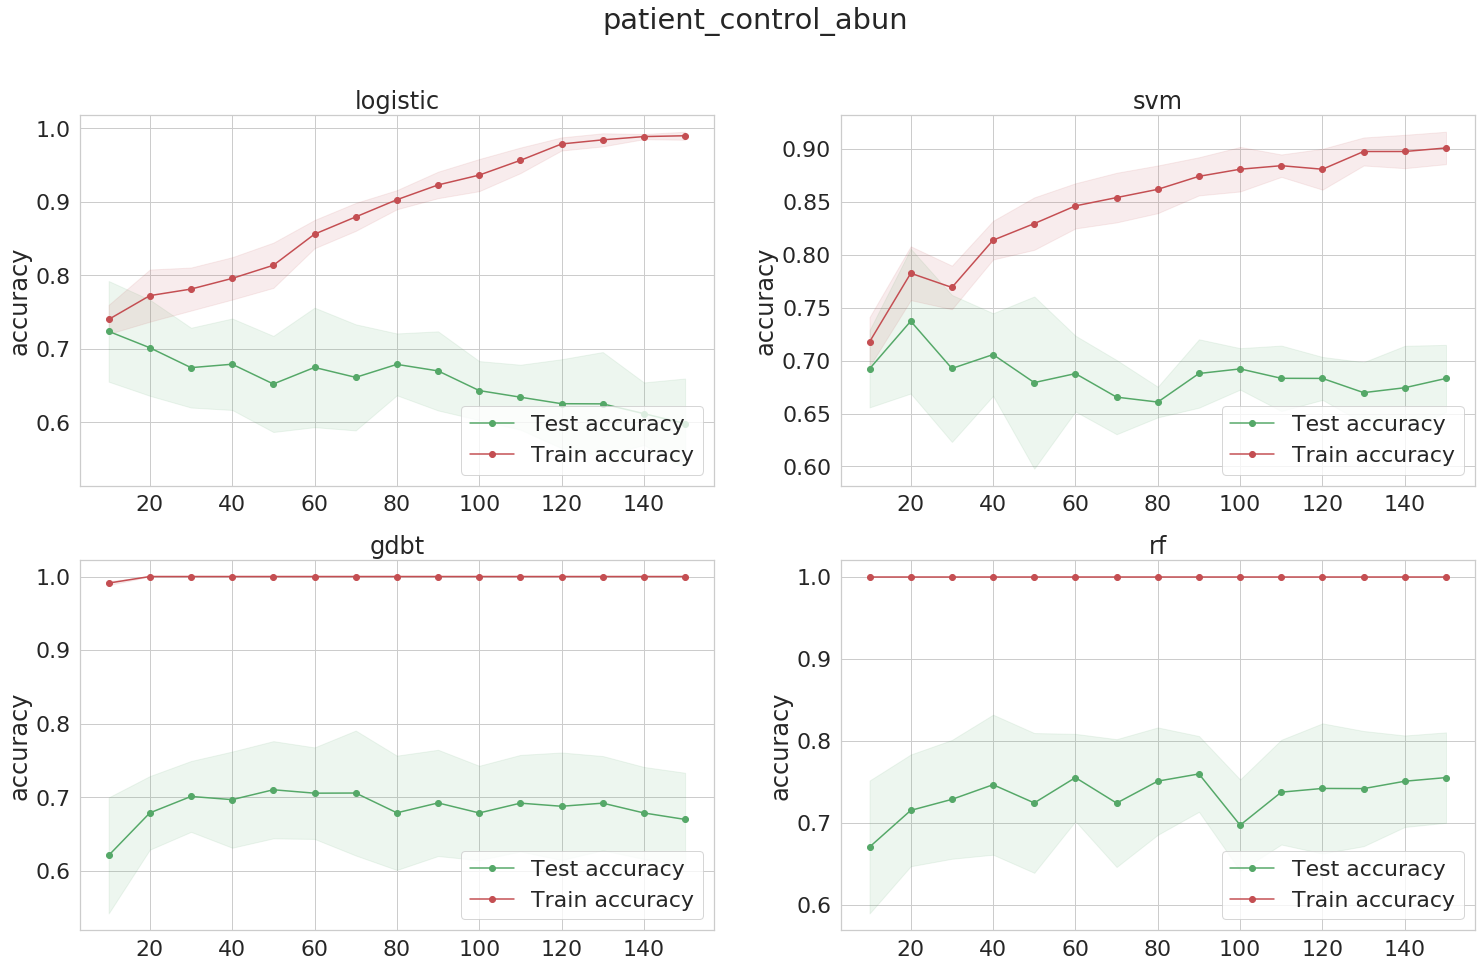

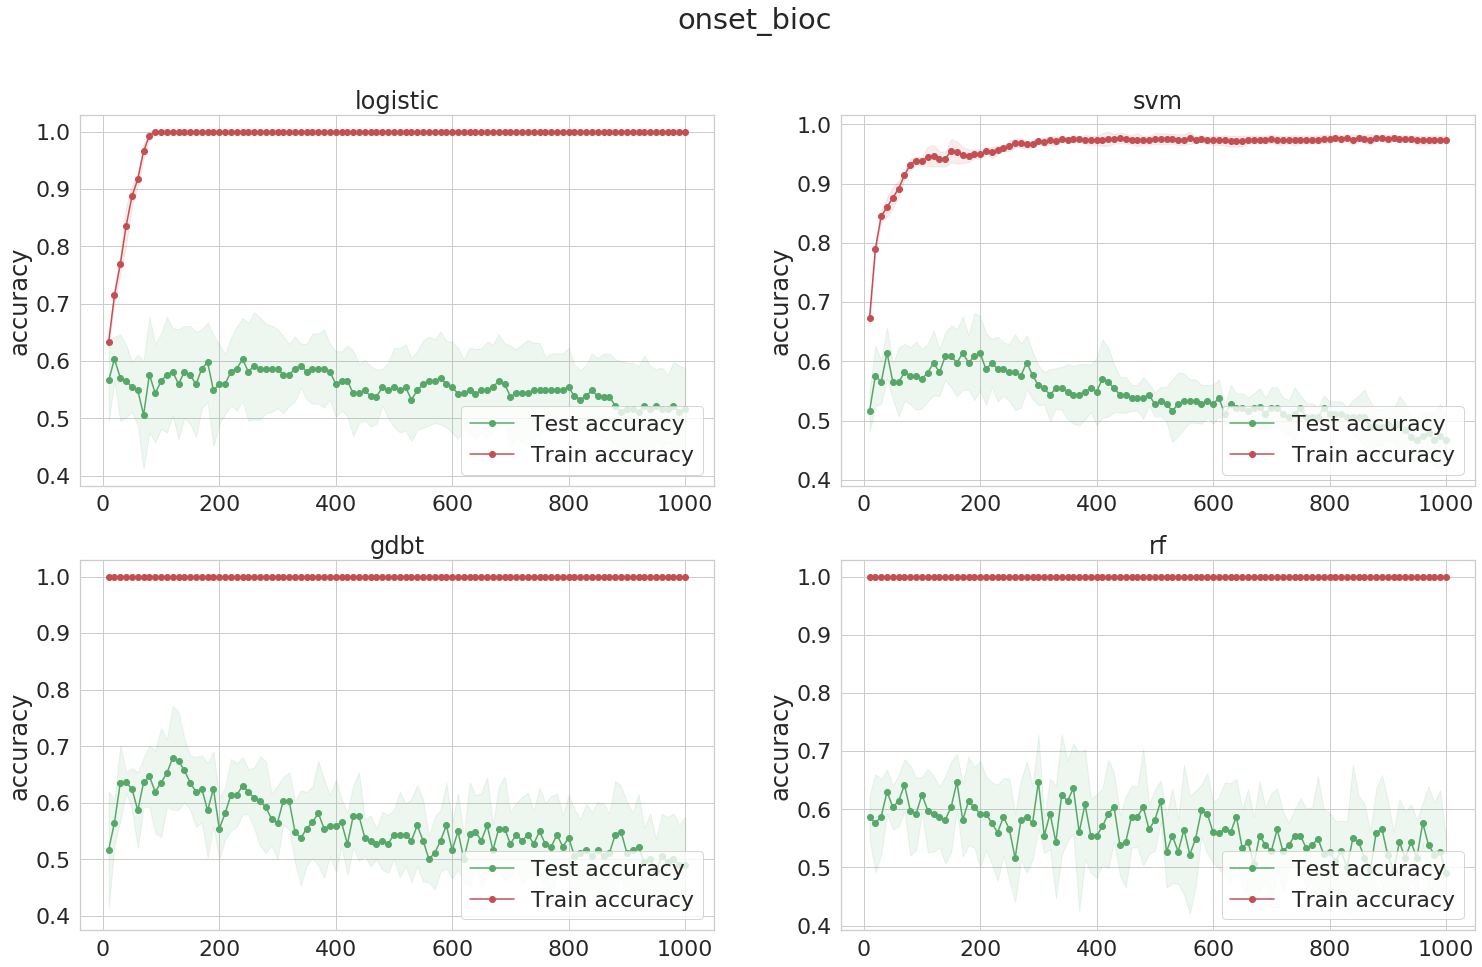

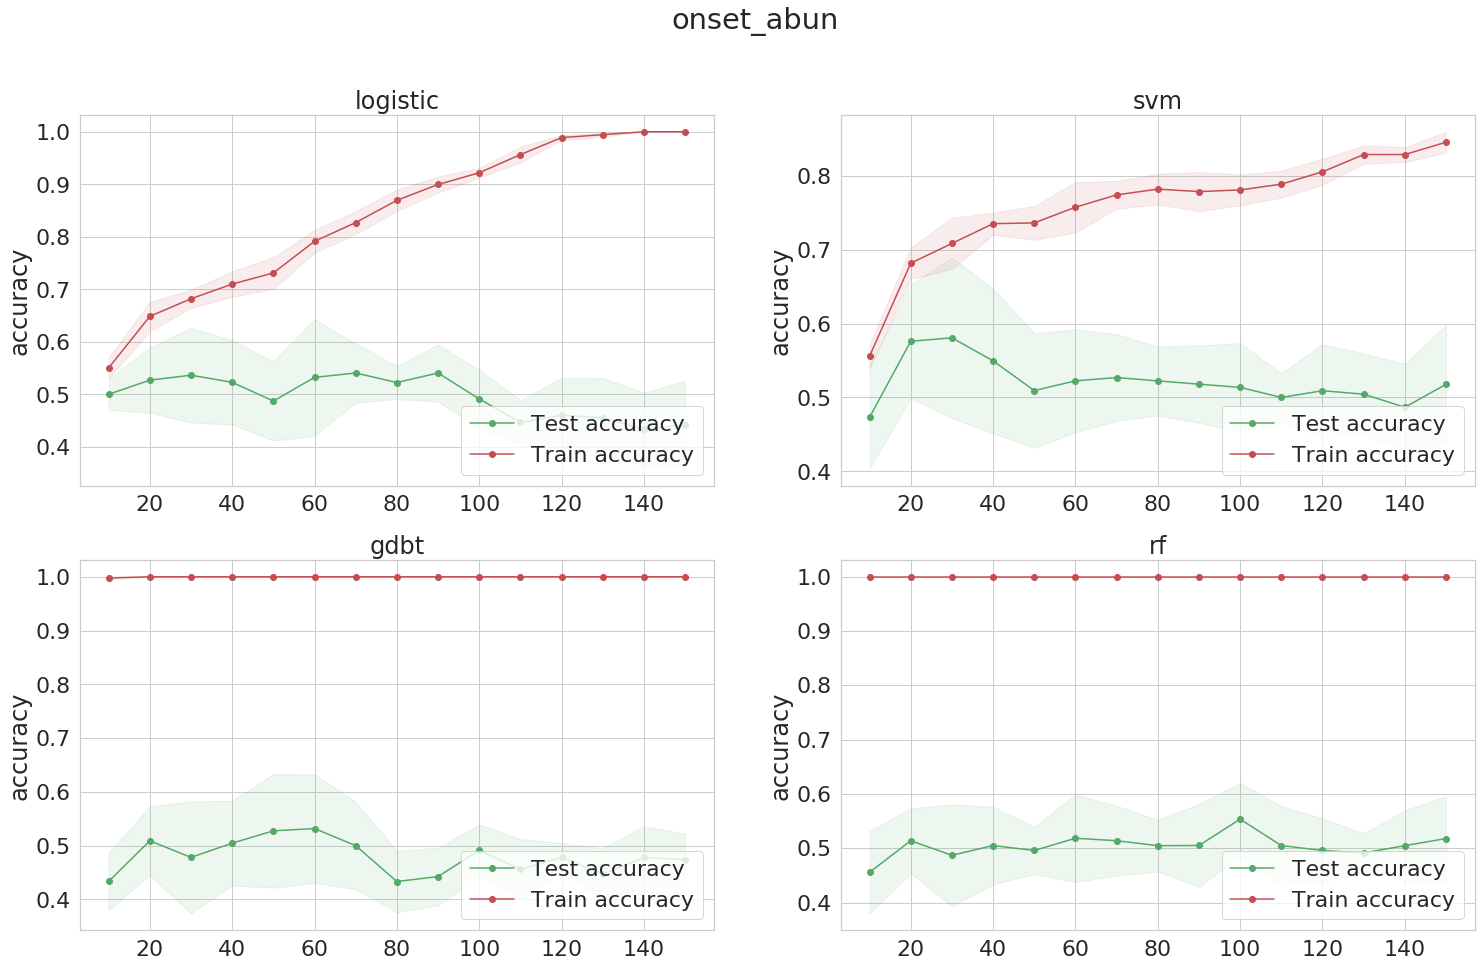

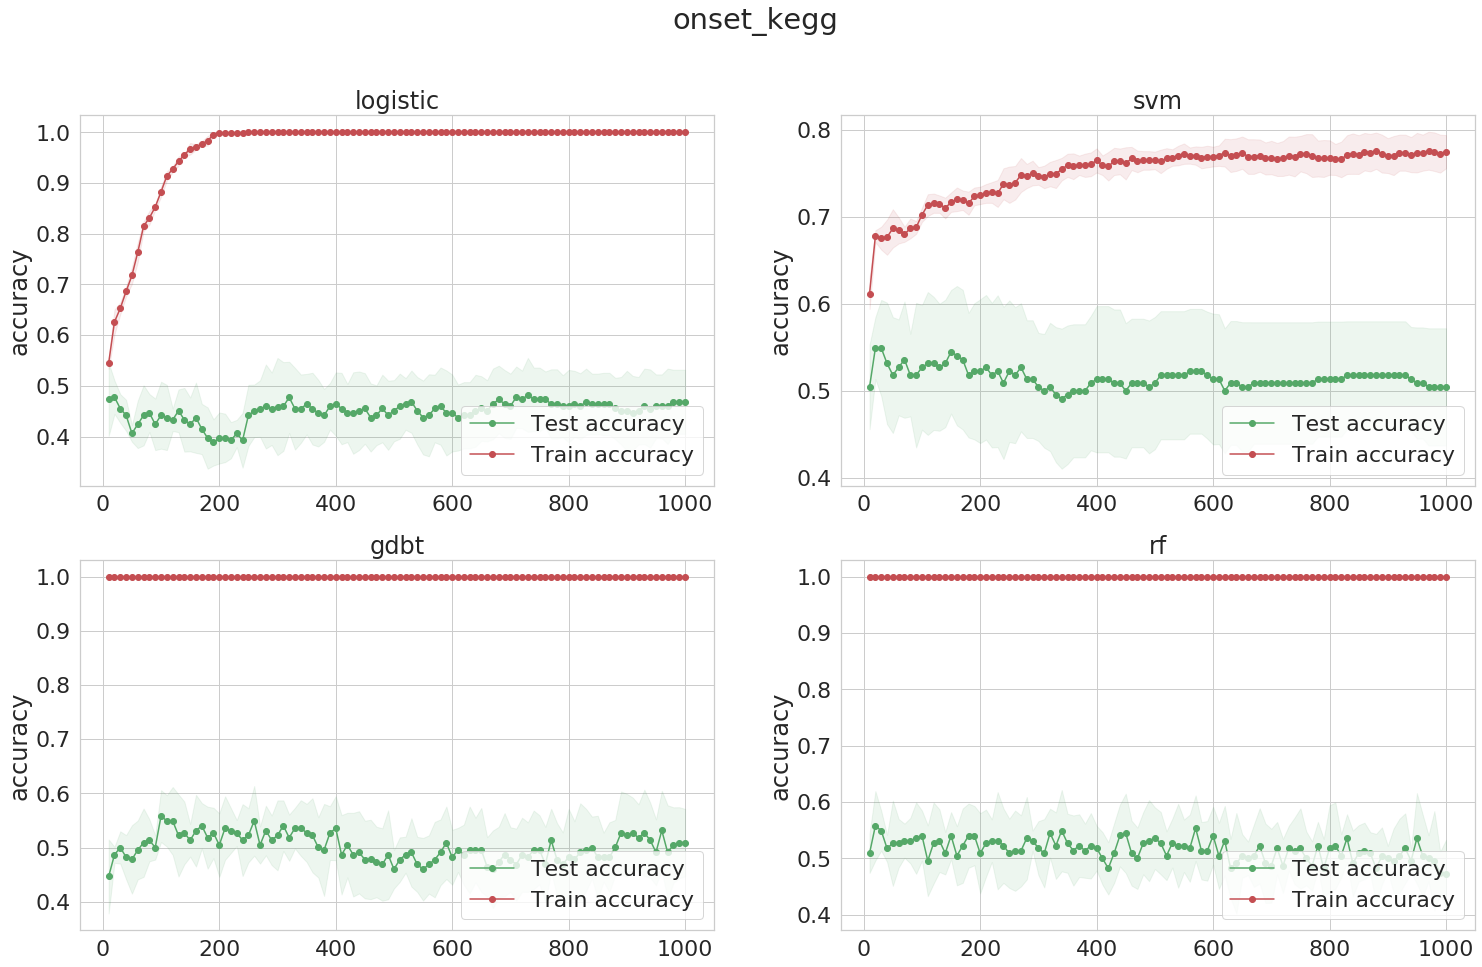

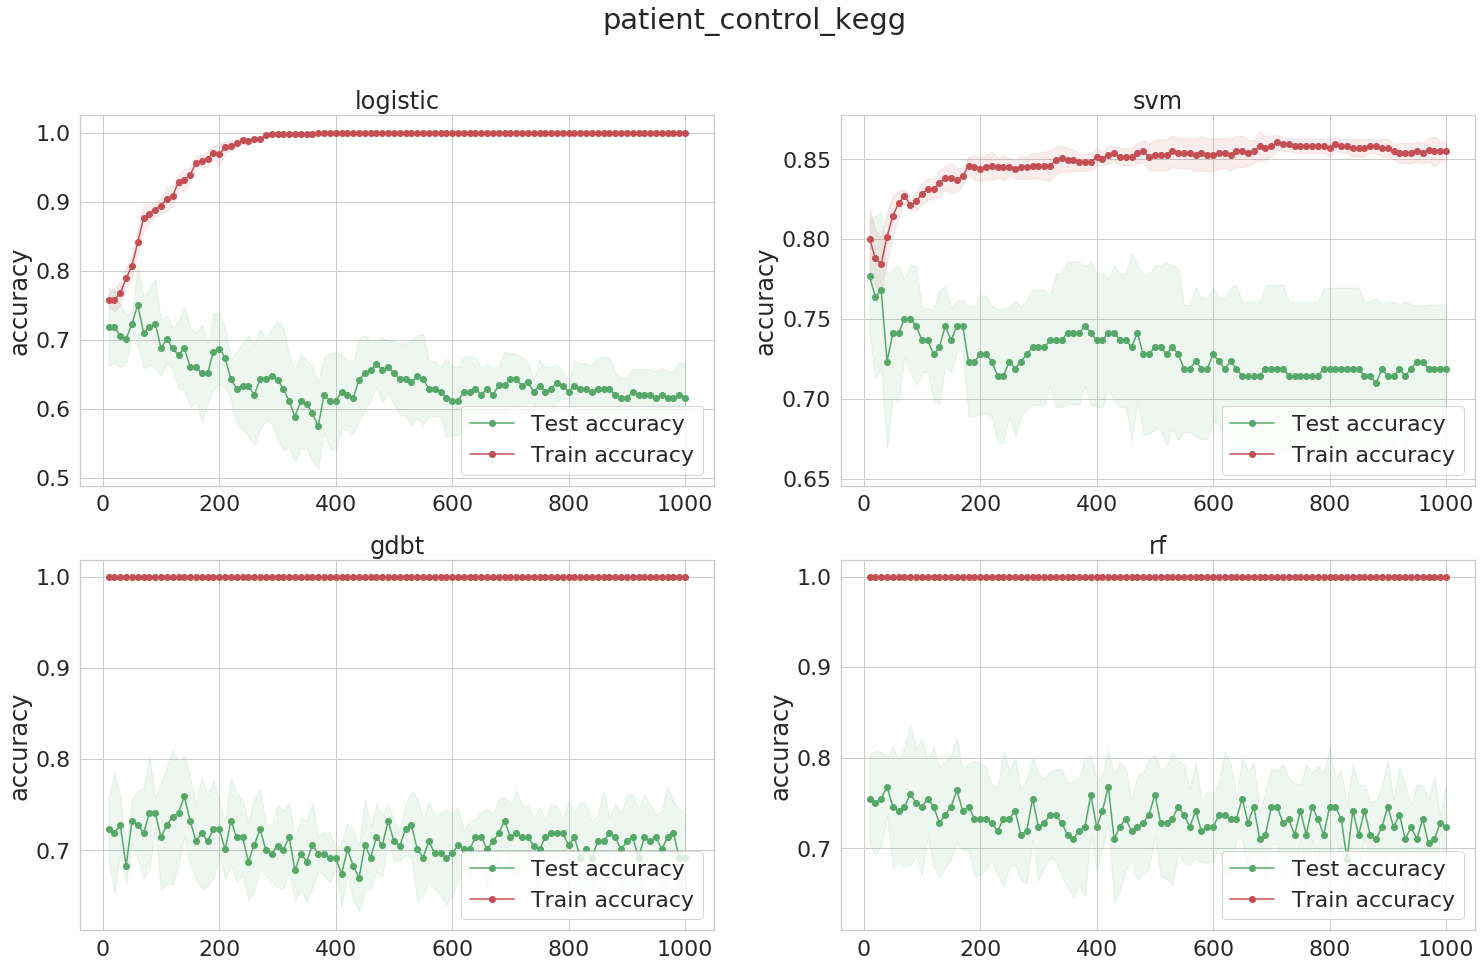

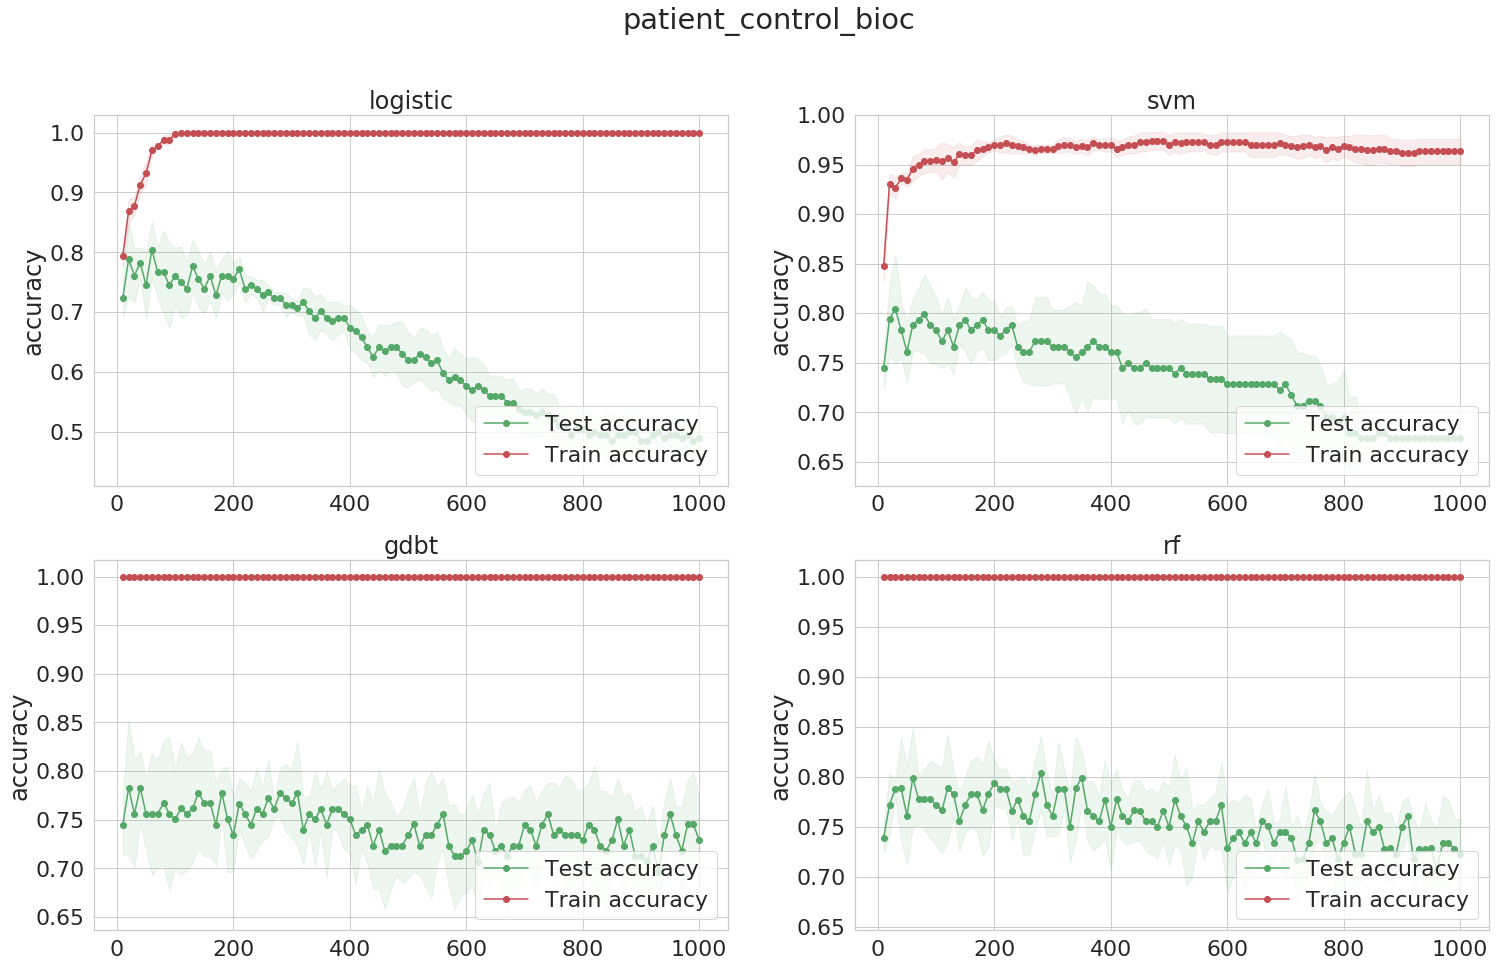

In [16]:
model_list = list(classifiers_list.keys())
for i in range(len(filenames)):
    fig_name = filenames[i].split("/")[-1].split("_fs_result.csv")[0]
    
    table = file[i]
    feature_num = set([int(i.split('_', 1)[1]) for i in list(table.index)])
    feature_num = sorted(list(feature_num))
    models = [(i.split('_', 1)[0]) for i in list(table.index)]
    table.loc[:,'models'] = models
    sns.set(style='whitegrid', font_scale=2)
    fig = plt.figure(figsize=(25,15))

    models = [(i.split('_', 1)[0]) for i in list(table.index)]
    for j in range(len(model_list)):
        ax = fig.add_subplot(2, 2, j+1)
        table_title = "%s" % (model_list[j])
        table_plot = table.loc[table['models'] == model_list[j]].iloc[:,:4]
        ax.fill_between(feature_num, 
                 table_plot.loc[:,'test_mean'].to_numpy() - table_plot.loc[:,'test_std'].to_numpy(),
                 table_plot.loc[:,'test_mean'].to_numpy() + table_plot.loc[:,'test_std'].to_numpy(), 
                 alpha=0.1, color="g")
        ax.plot(feature_num, table_plot.loc[:,'test_mean'].to_numpy(), 'o-', color="g", label="Test accuracy")
        ax.fill_between(feature_num, 
                 table_plot.loc[:,'train_mean'].to_numpy() - table_plot.loc[:,'train_std'].to_numpy(),
                 table_plot.loc[:,'train_mean'].to_numpy() + table_plot.loc[:,'train_std'].to_numpy(), 
                 alpha=0.1, color="r")
        ax.plot(feature_num, table_plot.loc[:,'train_mean'].to_numpy(), 'o-', color="r", label="Train accuracy")
        plt.ylabel('accuracy')
        plt.title(table_title)
        plt.legend(loc="lower right")
    plt.suptitle(fig_name)
    plt.show()

## Writing output for classification

In [84]:
y_full = meta_data.loc['study_ptorhc', :]
X = bioc_data[:].transpose()
y = y_full[X.index].to_numpy()
data_with_group = pd.concat([pd.DataFrame(y, columns=['group'], index=X.index), X], axis=1)
p_value_table = fs_p_value(data_with_group)
index = p_value_table.sort_values(by='p_val', axis=0, ascending=True).index[:400]
pd.concat([bioc_decode.loc[index,:], bioc_data.loc[index,:]], 
          axis=1).to_csv("%s/result/feature_selection/metabolomics_patient_control_table_for_classification.csv" % (root))

In [85]:
y_full = meta_data.loc['illness_duration', :]
X = bioc_data[:].transpose()
y = y_full[X.index].to_numpy()
data_with_group = pd.concat([pd.DataFrame(y, columns=['group'], index=X.index), X], axis=1)
p_value_table = fs_p_value(data_with_group)
index = p_value_table.sort_values(by='p_val', axis=0, ascending=True).index[:400]
pd.concat([bioc_decode.loc[index,:], bioc_data.loc[index,:]], 
          axis=1).to_csv("%s/result/feature_selection/metabolomics_onset_table_for_classification.csv" % (root))

In [87]:
y_full = meta_data.loc['study_ptorhc', :]
X = kegg_data[:].transpose()
y = y_full[X.index].to_numpy()
data_with_group = pd.concat([pd.DataFrame(y, columns=['group'], index=X.index), X], axis=1)
p_value_table = fs_p_value(data_with_group)
index = p_value_table.sort_values(by='p_val', axis=0, ascending=True).index[:1000]
pd.concat([kegg_decode.loc[index,:], kegg_data.loc[index,:]], 
          axis=1).to_csv("%s/result/feature_selection/kegg_gene_patient_control_table_for_classification.txt" % (root), 
                        sep = '\t')

In [86]:
y_full = meta_data.loc['illness_duration', :]
X = kegg_data[:].transpose()
y = y_full[X.index].to_numpy()
data_with_group = pd.concat([pd.DataFrame(y, columns=['group'], index=X.index), X], axis=1)
p_value_table = fs_p_value(data_with_group)
index = p_value_table.sort_values(by='p_val', axis=0, ascending=True).index[:1000]
pd.concat([kegg_decode.loc[index,:], kegg_data.loc[index,:]], 
          axis=1).to_csv("%s/result/feature_selection/kegg_gene_onset_table_for_classification.txt" % (root),
                        sep = '\t')